In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
from pathlib import Path
from tqdm import tqdm
from scipy.linalg import cholesky, solve_triangular
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter

In [4]:
class ProteinDataset(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.X, self.y, self.xres, self.af = torch.load(self.path / f'{id}.pt')
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.xres[i], self.af[i], self.y[i]

In [5]:
lengths = [4096, 512, 256, 256]
path = Path('ml_samples/'+'-'.join([str(l) for l in lengths]))
samples = [f.stem for f in path.iterdir()]

from lib.retrieve_data import retrieve_target_list
ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
targetlist = retrieve_target_list()
skip = [targetlist.loc[id, 'pdb_code'].upper() for id in ids]
samples = sorted(list(set(samples) - set(skip)))

train, test = train_test_split(samples, test_size=0.35, random_state=42)
torch.save((train, test), 'ml_data/split.pt')
# train, test = to ch.load('ml_data/split.pt')
train_dataset = ConcatDataset([ProteinDataset(s, path) for s in train])
test_dataset = ConcatDataset([ProteinDataset(s, path) for s in test])
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
len(train_dataset), len(test_dataset), len(train_dataset) + len(test_dataset)

(47572, 25179, 72751)

# Brute Force Search

In [6]:
X,xres,af,y = train_dataset[2]

h = 0.5
kdews = [1,1,1,1]
weights = torch.tensor(np.concatenate([np.array([w]*l) for w,l in zip(kdews, lengths)]))
kde = gaussian_kde(X, weights=weights, bw_method=h)
kde([0,0])
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())

[-1.81818182  1.81818182] 9.193181265651215e-05


In [ ]:
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))
h = 0.5
results = []
for i in range(0,10,2):
    wi = np.power(2,i)
    for j in range(0,10,2):
        wj = np.power(2,j)
        for k in range(0,10,2):
            wk = np.power(2,k)
            for l in tqdm(range(0,10,2)):
                wl = np.power(2,l)
                ws = [wi,wj,wk,wl]
                weights = np.concatenate([np.array([w]*l) for w,l in zip(ws, lengths)])
                for i in np.random.choice(len(train_dataset), 16):
                # for i,(x, xres, af, y) in enumerate(train_dataset):
                    print(i)
                    x, xres, af, y = train_dataset[i]
                    x = x.numpy()
                    y = y.numpy()
                    kde = gaussian_kde(x, weights=weights, bw_method=h)
                    probs = kde(grid).reshape(phi_grid.shape)
                    kdepeak = grid[:,probs.argmax()]
                    dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
                    results.append([wi,wj,wk,wl,dist])
                    # if i == 15:
                        # break
                    with open ('results_.csv', 'a') as f:
                        f.write(f'{wi},{wj},{wk},{wl},{dist}\n')
df = pd.DataFrame(results, columns=['w4', 'w5', 'w6', 'w7', 'da'])
df.to_csv('results.csv', index=False)

In [82]:
df = pd.read_csv('results.csv')
df['id'] = df.apply(lambda x: '-'.join([str(int(w)) for w in x[['w4', 'w5', 'w6', 'w7']]]), axis=1)

In [129]:
grouped = df.groupby(['w4', 'w5', 'w6', 'w7']).agg(n=('da', 'size'), da=('da', 'mean'), std=('da', 'std'), id=('id', lambda x: x.iloc[0])).reset_index()

In [141]:
grouped[grouped.id.isin(chosen_ids)]

,w4,w5,w6,w7,n,da,std,id
88,1,64,16,64,16,55.497319,52.311558,1-64-16-64
177,4,16,1,16,16,60.636091,71.179443,4-16-1-16
291,16,4,64,4,16,61.851658,75.841171,16-4-64-4
337,16,64,16,16,16,62.103944,55.639732,16-64-16-16
360,16,256,16,1,16,57.602896,54.944407,16-256-16-1
501,256,1,1,4,16,50.555986,42.725184,256-1-1-4
608,256,256,4,64,16,62.775770,56.630056,256-256-4-64


In [119]:
chosen_ids = grouped[grouped.da < grouped.da.quantile(0.01)].id.values
chosen_df = df[df.id.isin(chosen_ids)]

<Axes: ylabel='da'>

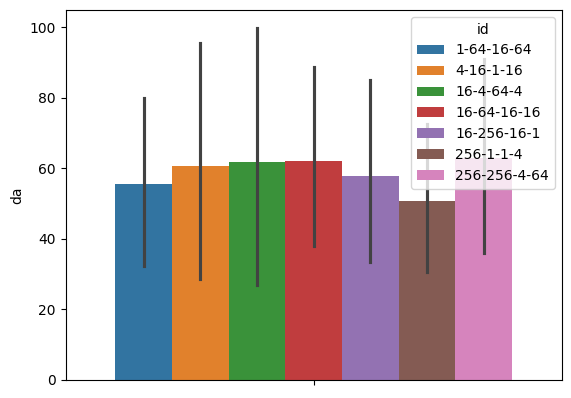

In [139]:
sns.barplot(data=chosen_df, y='da', hue='id')

<Axes: xlabel='da', ylabel='Count'>

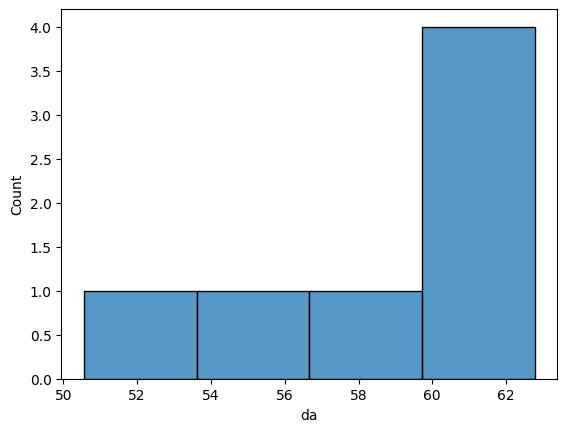

In [135]:
sns.histplot(grouped[grouped.da < grouped.da.quantile(0.01)], x='da')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     da   R-squared (uncentered):                   0.471
Model:                            OLS   Adj. R-squared (uncentered):              0.471
Method:                 Least Squares   F-statistic:                              2223.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):                        0.00
Time:                        12:34:17   Log-Likelihood:                         -58806.
No. Observations:               10000   AIC:                                  1.176e+05
Df Residuals:                    9996   BIC:                                  1.176e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
w4             0.2617      0.008     31.951      0.000       0.246       0.278
w5             0.2389      0.008     29.173      0.000       0.223       0.255
w6             0.2432      0.008     29.697      0.000       0.227       0.259
w7             0.2337      0.008     28.532      0.000       0.218       0.250
==============================================================================
Omnibus:                      158.449   Durbin-Watson:                   1.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.273
Skew:                          -0.068   Prob(JB):                     2.05e-21
Kurtosis:                       2.542   Cond. No.                         1.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

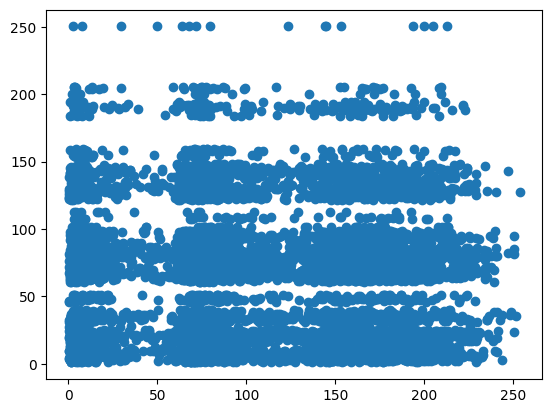

In [128]:
import statsmodels.api as sm

X = df[['w4', 'w5', 'w6', 'w7']]
# X = sm.add_constant(X)
y = df['da']
model = sm.OLS(y, X).fit()

yhat = model.predict(X)
plt.plot(df['da'], yhat, 'o')
model.summary()

# KDE from scratch - backprop

In [82]:
h = 2
h_mat = torch.eye(2) * h
print(h_mat)
h_mat = torch.inverse(h_mat) # 2x2 matrix
print(h_mat)
x = torch.tensor([1.,.23]) # 2x1 "column vector"
print(x)
this = x @ h_mat # x.T @ h_mat: 1x2 @ 2x2 = 1x2 "row vector"
print('this',this)
print('x=',this @ x) # 1x2 @ 2x1 = 1x1 "scalar"

# shortcut
print('x=',x.pow(2).sum() / h)

tensor([[2., 0.],
        [0., 2.]])
tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]])
tensor([1.0000, 0.2300])
this tensor([0.5000, 0.1150])
x= tensor(0.5264)
x= tensor(0.5264)


In [153]:
X.T

tensor([[-119.2000,  113.6000],
        [-115.3000,  112.6000],
        [-117.4000,  132.1000],
        ...,
        [ -51.7000,  130.8000],
        [ -34.8000,  114.3000],
        [ -74.5000,  131.0000]])

In [162]:
from scipy.linalg import solve_triangular
print(X.shape)
solve_triangular(cho_cov, X, lower=True).shape

torch.Size([2, 5120])


(2, 5120)

In [183]:
kdews.grad

tensor([5120., 5120., 5120., 5120.])

In [180]:
kdews = torch.tensor([1.,1.,1.,1.], requires_grad=True)
weights = torch.cat([kdews.repeat(l) for l in lengths])
weights.sum().backward()

In [185]:
diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))
torch.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)

tensor(144.0303)

In [186]:
y

tensor([-81.9605, 121.4925])

tensor([ 0.9839, -0.2462, -0.3725, -0.3651])
tensor([-1.8182,  1.8182], dtype=torch.float64) tensor(9.1932e-05, dtype=torch.float64)


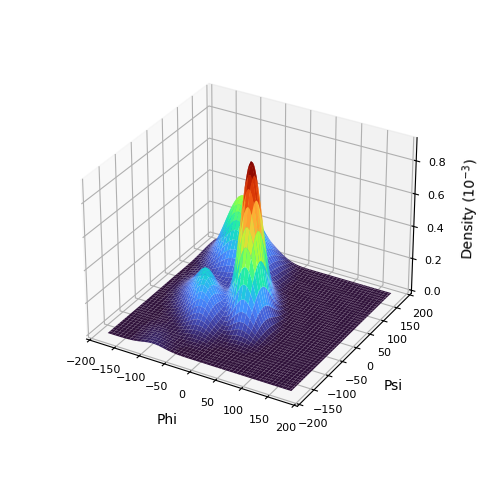

In [214]:
X,xres,af,y = train_dataset[2]

from scipy.stats import gaussian_kde
from scipy.linalg import cholesky
from tqdm import tqdm
kdews = torch.tensor([0.25, 0.25, 0.25, 0.25], requires_grad=True)
weights = torch.cat([kdews[i].repeat(l) for i,l in enumerate(lengths)])
# weights = weights / weights.sum()
# X = X.numpy()
# X
# plt.plot(weights)

# Kernel Density Estimation
h = 0.5
cov = np.cov(X, rowvar=True, aweights=weights.detach())
cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal
def K(x):
    # 2 dimensional standard normal distribution
    # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
    return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
def kde(xi):
    xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
    if xi.ndim == 1:
        xi = xi.unsqueeze(1)
    points = torch.tensor(solve_triangular(cho_cov, X, lower=True))
    xi = torch.tensor(solve_triangular(cho_cov, xi, lower=True))
    xi = xi.T.unsqueeze(-1)
    likelihood = K(points.unsqueeze(0) - xi) * weights
    likelihood = likelihood.sum(dim=1) / weights.sum()
    return likelihood

# Find most likely dihedral angles
xray_likelihood = kde(y)
nll = -torch.log(xray_likelihood)
nll.backward()
print(kdews.grad)

phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = torch.tensor(np.vstack([phi_grid.ravel(), psi_grid.ravel()]))
probs = kde(grid).reshape(phi_grid.shape).detach()
kdepeak = grid[:,probs.argmax()]
print(kdepeak, probs.max())

# diff = lambda x1, x2: torch.min(torch.abs(x1 - x2), 360 - torch.abs(x1 - x2))
# dist_to_xray = torch.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
# print(dist_to_xray.backward())

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.dist = 5
plt.tight_layout()

In [ ]:
kde = gaussian_kde(X, weights=weights, bw_method=h)
kde([0,0])
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
# ax.dist = 5
plt.tight_layout()

In [66]:
torch.log(torch.tensor(1.))

tensor(0.)

In [98]:
len(trainloader)

93

In [99]:
next(iter(trainloader))[3].shape

torch.Size([512, 2])

In [145]:
torch.pow(2, torch.tensor([0.,5.,6.,7.]))

tensor([  1.,  32.,  64., 128.])

In [151]:
kdewlogs

tensor([1.0000, 5.0000, 6.0000, 7.0000], requires_grad=True)

In [ ]:
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular

kdewlogs = torch.tensor([1.,5.,6.,7.], requires_grad=True)
kdews = torch.pow(2, kdewlogs)
weights = torch.cat([kdews[i].repeat(l) for i,l in enumerate(lengths)])
optimizer = torch.optim.SGD([kdewlogs], lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam([kdewlogs], lr=3e-4)

h = 0.5

nlls = []
best_weights = kdews
best_lost = 1e9
for Xbatch,xres,af,ybatch in trainloader:
    nll = 0
    kdews = torch.pow(2, kdewlogs)
    weights = torch.cat([kdews[i].repeat(l) for i,l in enumerate(lengths)])
    for X,y in tqdm(zip(Xbatch, ybatch)):
        # Kernel Density Estimation
        cov = np.cov(X, rowvar=True, aweights=weights.detach())
        cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
        h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal
        def K(x):
            # 2 dimensional standard normal distribution
            # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
            return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
        def kde(xi):
            xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
            if xi.ndim == 1:
                xi = xi.unsqueeze(1)
            points = torch.tensor(solve_triangular(cho_cov, X, lower=True))
            xi = torch.tensor(solve_triangular(cho_cov, xi, lower=True))
            xi = xi.T.unsqueeze(-1)
            likelihood = K(points.unsqueeze(0) - xi) * weights
            likelihood = likelihood.sum(dim=1) / weights.sum()
            return likelihood
        
        # Optimize xray prob
        xray_likelihood = kde(y)
        if xray_likelihood == 0:
            continue
        nlli = -torch.log(xray_likelihood)
        nll += nlli
    if nll < best_lost:
        best_lost = nll
        best_weights = kdews
    optimizer.zero_grad()
    nll.backward()
    optimizer.step()
    print(nll, kdewlogs.grad, kdewlogs, torch.pow(2, kdewlogs))
    nlls.append(nll)
nlls = torch.tensor(nlls)

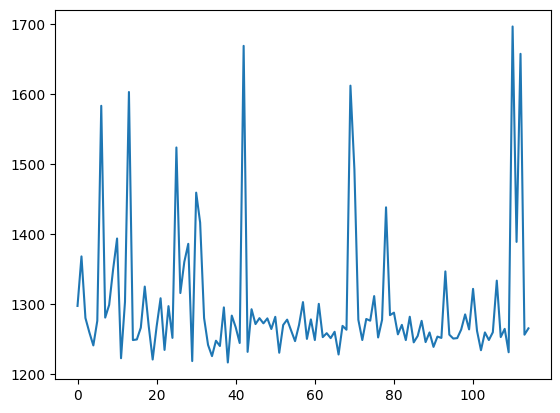

In [158]:
plt.plot(nlls.detach())

[-118.18181818  125.45454545] 4.965032505833786e-05
tensor([-66.2305, -35.4409]) [2.57286341e-05]


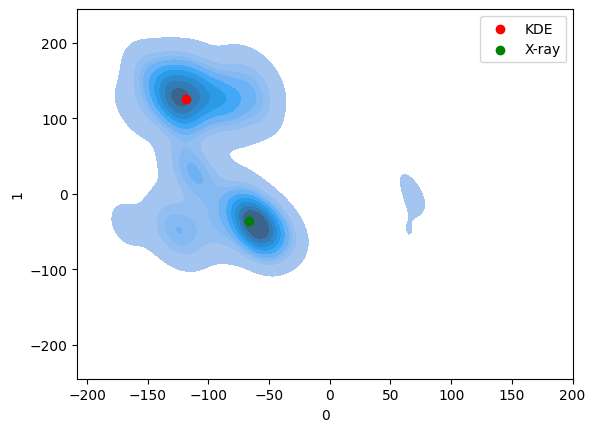

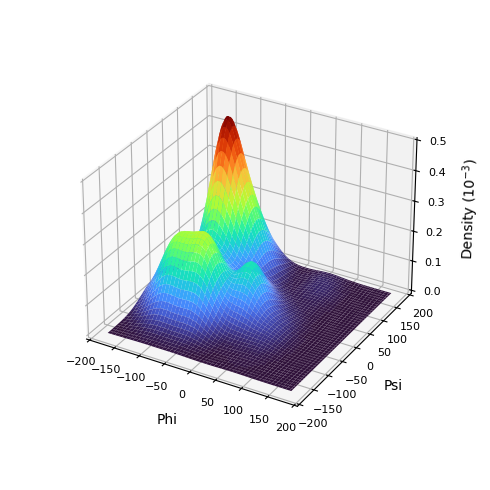

In [135]:
optim_kdews = torch.tensor([0.2458, 0.6339, 5.8508, 0.6577])
# optim_kdews = torch.tensor([1.,32.,64.,128.])
# optim_kdews = torch.tensor([1.,1.,1.,1.])
weights = torch.cat([optim_kdews[i].repeat(l) for i,l in enumerate(lengths)])

X,xres,af,y = test_dataset[2]

# Kernel Density Estimation
kde = gaussian_kde(X, weights=weights, bw_method=h)
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())
print(y, kde(y))


X = X.clone()
X[X==0] = np.nan
sns.kdeplot(pd.DataFrame(X.numpy().T), x=0, y=1, fill=True)
# plt.scatter(X[0], X[1])
plt.scatter(kdepeak[0], kdepeak[1], c='r', label='KDE')
plt.scatter(y[0], y[1], c='g', label='X-ray')
plt.legend()

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
# ax.dist = 5
plt.tight_layout()

# Smarter brute force

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
from pathlib import Path
from tqdm import tqdm
from scipy.linalg import cholesky, solve_triangular
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter
from lib.retrieve_data import retrieve_target_list
from lib import MultiWindowQuery
import pickle

In [54]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'
casp_protein_ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
# targetlist = retrieve_target_list()
# pdb_codes = [targetlist.loc[id, 'pdb_code'].upper() for id in casp_protein_ids]
winsizes = [4,5,6,7]
samples = {w:[] for w in winsizes}
for id in casp_protein_ids:
    da = DihedralAdherence(id, winsizes, PDBMINE_URL, PROJECT_DIR)
    da.load_results()
    seqs = da.xray_phi_psi[['seq_ctxt', 'res', 'phi', 'psi']].rename(columns={'seq_ctxt': 'seq'})
    for i,row in tqdm(seqs.iterrows()):
        if np.isnan(row.phi) or np.isnan(row.psi):
            continue
        y = np.array([row.phi, row.psi])
        n_matches = []
        phi_psis = []
        for q in da.queries:
            inner_seq = q.get_subseq(row.seq)
            matches = q.results[q.results.seq == inner_seq][['seq', 'phi', 'psi']]
            n_matches.append(matches.shape[0])
            phi_psis.append(matches[['phi', 'psi']].values)
        if n_matches[3] > 0:
            samples[7].append((phi_psis, y))
        elif n_matches[2] > 0:
            samples[6].append((phi_psis, y))
        elif n_matches[1] > 0:
            samples[5].append((phi_psis, y))
        elif n_matches[0] > 0:
            samples[4].append((phi_psis, y))
with open('casp_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


396it [00:12, 31.54it/s]


Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found


167it [00:05, 33.16it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


162it [00:01, 84.87it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


215it [00:00, 674.83it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


824it [00:43, 18.77it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


361it [00:10, 33.80it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


313it [00:01, 201.73it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


267it [00:06, 43.36it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


222it [00:02, 105.08it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


204it [00:02, 89.86it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


266it [00:07, 37.14it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


611it [00:06, 90.19it/s]


In [57]:
samples = pickle.load(open('casp_samples.pkl', 'rb'))

In [66]:
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular


def run_kde_grid_search(samples, fn, values, n_windows, winsizes):
    phi_psi_grid_size = 50
    def get_preweights(X):
        phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, phi_psi_grid_size), np.linspace(-180, 180, phi_psi_grid_size))
        grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
        n_eff = X.shape[0]
        if n_eff == 0:
            print('0')
            return torch.zeros(*phi_grid.shape, 1), 0
        X = X.T
        h=0.5
        cov = np.cov(X, rowvar=True)
        cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
        h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal

        def K(x):
            # 2 dimensional standard normal distribution
            # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
            return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
        def kde_pre_weights(xi):
            xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
            if xi.ndim == 1:
                xi = xi.unsqueeze(1)
            points = torch.tensor(solve_triangular(cho_cov, X, lower=True))
            xi = torch.tensor(solve_triangular(cho_cov, xi, lower=True))
            xi = xi.T.unsqueeze(-1)
            likelihood = K(points.unsqueeze(0) - xi)# * weights
            # likelihood = likelihood.sum(dim=1) / weights.sum()
            return likelihood

        preweights = kde_pre_weights(grid).reshape(*phi_grid.shape,-1)
        return preweights, n_eff

    diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))

    import itertools
    combinations = [comb for comb in itertools.product(values, repeat=len(winsizes)) if sum(comb) == 1]
    if len(winsizes) == 4:
        combinations = [tuple(np.array([1,32,64,128]) / np.array([1,32,64,128]).sum())] + combinations
    print(len(combinations), combinations)

    results = []
    for sample in tqdm(samples):
        X,y = sample
        try:
            preweights = []
            n_effs = []
            for i in range(n_windows):
                preweight, n_eff = get_preweights(X[i])
                preweights.append(preweight)
                n_effs.append(n_eff)
            n_effs.append(n_eff)

            phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, phi_psi_grid_size), np.linspace(-180, 180, phi_psi_grid_size))
            grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
        except Exception as e:
            print('exception', e)
            continue
        raise ValueError('stop')
        for ws in combinations:
            kdews = torch.tensor(ws)
            n = [w*n for w,n in zip(kdews, n_effs)]
            probs = torch.stack([(p * kdews[i]).sum(dim=-1) for i,p in enumerate(preweights)]).sum(dim=0) / sum(n)
            kdepeak = grid[:,probs.argmax()]
            dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
            # print(y, kdepeak, probs.max(), dist)
            results.append([*ws,dist.item()])
        
        if i % 100 == 0:
            results_df = pd.DataFrame(results, columns=[*[f'w{w}' for w in winsizes], 'da'])
            results_df.to_csv(fn, index=False)
    results_df = pd.DataFrame(results, columns=[*[f'w{w}' for w in winsizes], 'da'])
    results_df.to_csv(fn, index=False)

In [67]:
# all windows:
grid_size = 2
values = np.linspace(0, 1, grid_size).round(5)
# run_kde_grid_search(samples[7], 'results_w7.csv', values, 4)

# 6 and below:
# run_kde_grid_search(samples[6], 'results_w6.csv', values, [4,5,6])

# 5 and 4:
run_kde_grid_search(samples[5], 'results_w5.csv', values, 2, [4,5])


2 [(0.0, 1.0), (1.0, 0.0)]


  0%|          | 0/874 [00:00<?, ?it/s]

[-51.88034096 -48.91033961] 4 [(222, 2), (68, 2), (0, 2), (0, 2)]


ValueError: stop

In [43]:
df = pd.read_csv('results_w5.csv')
# df['id'] = df.apply(lambda x: '-'.join([str(w) for w in x[['w4', 'w5', 'w6', 'w7']]]), axis=1)
# df['id'] = df.apply(lambda x: '-'.join([str(w) for w in x[['w4', 'w5', 'w6']]]), axis=1)
df['id'] = df.apply(lambda x: '-'.join([str(w) for w in x[['w4', 'w5']]]), axis=1)
current_kde_id = df.iloc[0].id
df_orig = df.copy()
df = df[df.id != current_kde_id]

In [44]:
df.groupby('id').size()

id
0.2-0.8    644
0.4-0.6    644
0.6-0.4    644
0.8-0.2    644
1.0-0.0    644
dtype: int64

In [45]:
df['w4'].unique()

array([0.2, 0.4, 0.6, 0.8, 1. ])

Text(0.5, 0.98, 'Dihedral Angle Adherence for 35 different combinations of kde weights w$\\in$[0, 0.2, 0.4, 0.6, 0.8, 1]')

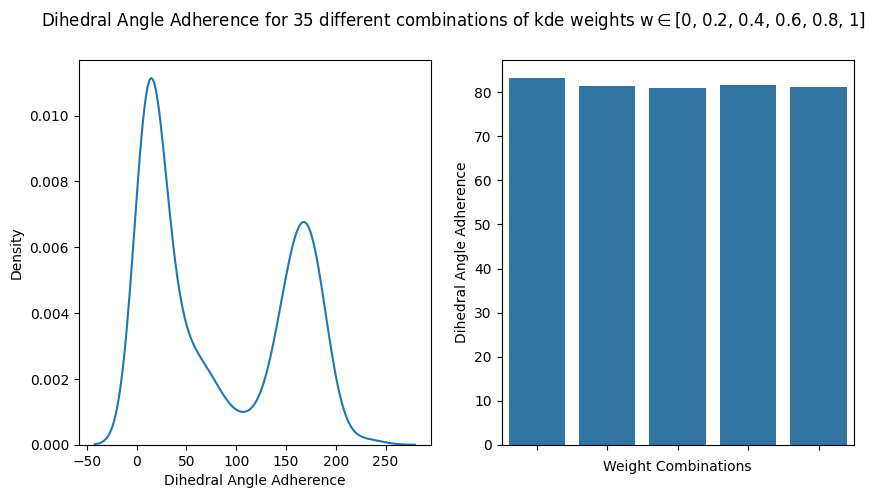

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.kdeplot(df, x='da', ax=axes[0])
axes[0].set_xlabel('Dihedral Angle Adherence')
sns.barplot(data=df, y='da', x='id', ax=axes[1], errorbar=None)
axes[1].set_xticklabels([]);
axes[1].set_xlabel('Weight Combinations')
axes[1].set_ylabel('Dihedral Angle Adherence')
fig.suptitle(r'Dihedral Angle Adherence for 35 different combinations of kde weights w$\in$[0, 0.2, 0.4, 0.6, 0.8, 1]')

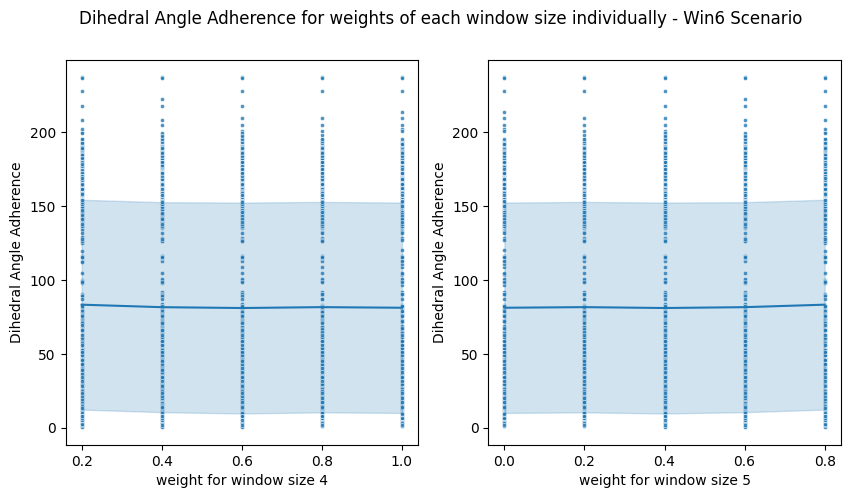

In [48]:
# fig, axes = plt.subplots(2,2, figsize=(10,10))
fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Dihedral Angle Adherence for weights of each window size individually - Win6 Scenario')
for i in range(2):
    # ax = axes[i//2,i%2]
    ax = axes[i]
    sns.scatterplot(data=df, x=f'w{i+4}', y='da', ax=ax, alpha=0.8, marker='.')
    # sns.violinplot(data=df, x=f'w{i+4}', y='da', ax=ax)
    ave = df.groupby(f'w{i+4}').mean(numeric_only=True)
    sns.lineplot(data=ave, x=ave.index, y='da', ax=ax)
    ax.fill_between(ave.index, ave['da'] - df.groupby(f'w{i+4}').std(numeric_only=True)['da'], ave['da'] + df.groupby(f'w{i+4}').std(numeric_only=True)['da'], alpha=0.2, color='tab:blue')
    ax.set_ylabel('Dihedral Angle Adherence')
    ax.set_xlabel(f'weight for window size {i+4}')
    # print(ave)

Text(0.5, 0, 'weight for each window size')

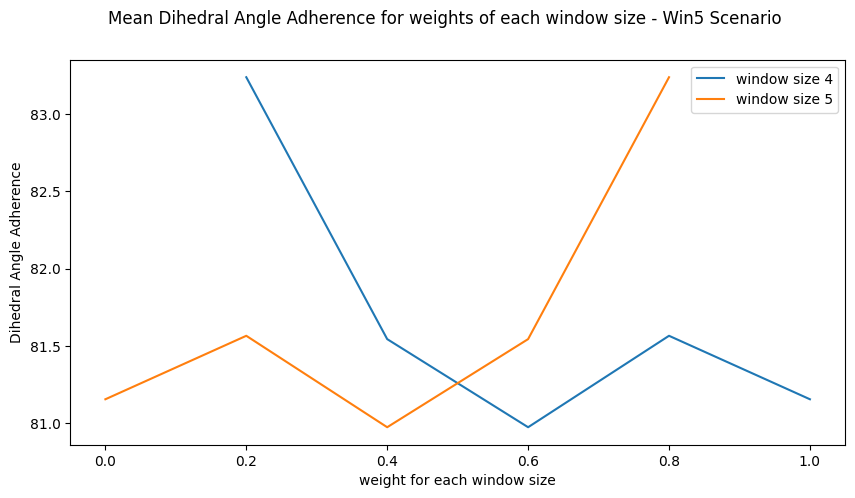

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Mean Dihedral Angle Adherence for weights of each window size - Win5 Scenario')
for i in range(2):
    # sns.scatterplot(data=df, x=f'w{i+4}', y='da', ax=ax, alpha=0.8, marker='.')
    # sns.violinplot(data=df, x=f'w{i+4}', y='da', ax=ax)
    ave = df.groupby(f'w{i+4}').mean(numeric_only=True)
    sns.lineplot(data=ave, x=ave.index, y='da', ax=ax, label='window size '+str(i+4))
    # ax.fill_between(ave.index, ave['da'] - df.groupby(f'w{i+4}').std(numeric_only=True)['da'], ave['da'] + df.groupby(f'w{i+4}').std(numeric_only=True)['da'], alpha=0.2)
ax.set_ylabel('Dihedral Angle Adherence')
ax.set_xlabel(f'weight for each window size')
    # print(ave)

    w4   w5         da       id
1  0.2  0.8  34.827565  0.2-0.8
2  0.4  0.6  34.827565  0.4-0.6
3  0.6  0.4  34.827565  0.6-0.4
4  0.8  0.2  34.827565  0.8-0.2
5  1.0  0.0  34.827565  1.0-0.0


/tmp/ipykernel_3415724/2666317630.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


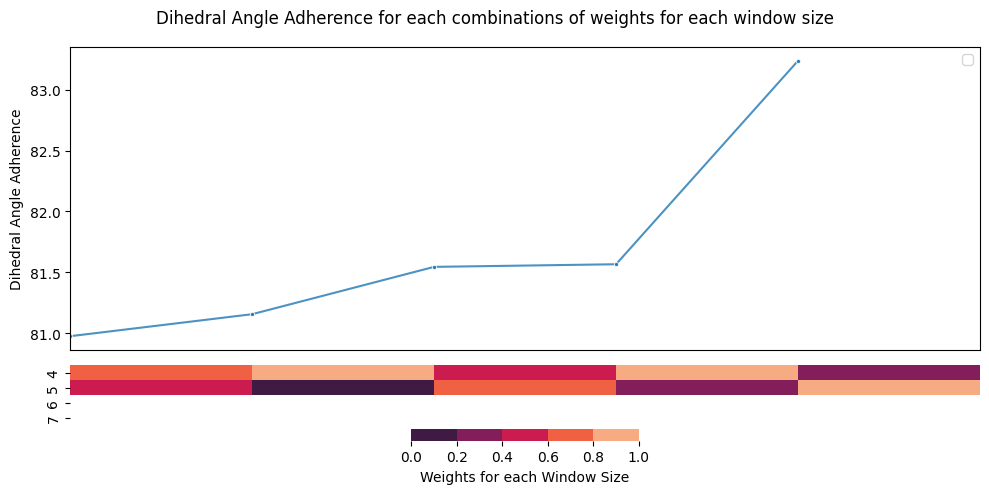

In [52]:
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4,1]})
# fig = plt.figure(figsize=(10,7))
# gs = gridspec.GridSpec(2,1, height_ratios=[2,1])

ax = axes[0]
fig.suptitle('Dihedral Angle Adherence for each combinations of weights for each window size')
grouped = df.groupby('id').agg(n=('da', 'size'), da=('da', 'mean'), std=('da', 'std')).sort_values('da')
grouped.index = grouped.index.str.replace('-', ', ')
sc = sns.scatterplot(data=grouped, x=np.arange(len(grouped)), y='da', alpha=0.8, marker='.', ax=ax)
sns.lineplot(data=grouped, x=np.arange(len(grouped)), y='da', alpha=0.8, marker='.', ax=ax)
ax.set_xlabel('Combinations of weights for each window size')
ax.set_ylabel('Dihedral Angle Adherence')
print(df.head())

# ax.axhline(df_orig[df_orig.id == current_kde_id].da.mean(), xmin=0, xmax=len(grouped), color='black', zorder=-1, label='Current KDE Weights')
ax.legend()

combs = np.array(list(pd.Series(grouped.index).apply(lambda x: [float(w) for w in x.split(',')]).values))
# cbar on bottom
palette = sns.color_palette("rocket", len(df.w4.unique()))
cmap = ListedColormap(palette)
sns.heatmap(combs.T, ax=axes[1], cbar=True, cbar_kws={'orientation': 'horizontal'}, cmap=cmap)
cbar = axes[1].collections[0].colorbar
cbar.set_label('Weights for each Window Size')
axes[1].set_xticks([])
axes[1].set_xticklabels([])
axes[1].set_yticks(np.arange(4)+0.5)
axes[1].set_yticklabels(np.arange(4)+4)
plt.tight_layout()

Text(0, 0.5, 'Dihedral Angle Adherence')

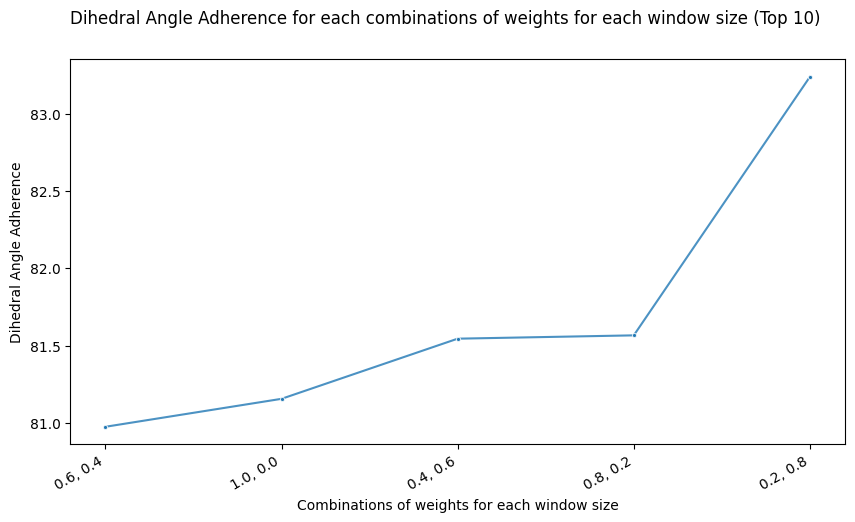

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Dihedral Angle Adherence for each combinations of weights for each window size (Top 10)')
grouped = df.groupby('id').agg(n=('da', 'size'), da=('da', 'mean'), std=('da', 'std')).sort_values('da').head(10)
grouped.index = grouped.index.str.replace('-', ', ')
sns.scatterplot(data=grouped, x=grouped.index, y='da', alpha=0.8, marker='.', ax=ax)
sns.lineplot(data=grouped, x=grouped.index, y='da', alpha=0.8, marker='.', ax=ax)
# ax.axhline(df_orig[df_orig.id == current_kde_id].da.mean(), xmin=0, xmax=len(grouped), color='black', zorder=-1, label='Current KDE Weights')
ax.set_xticks(grouped.index)
ax.set_xticklabels(grouped.index, rotation=30, ha='right');
ax.set_xlabel('Combinations of weights for each window size')
ax.set_ylabel('Dihedral Angle Adherence')
# ax.legend()

# Examples of Results

In [4]:
# test when da is high to see if new weights help
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
da = DihedralAdherence('T1024', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde')
da.load_results_da()
# da.compute_das()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
No AlphaFold phi-psi data found


In [5]:
x = da.xray_phi_psi[da.xray_phi_psi.n_samples_list.apply(lambda x: (eval(x)[-1] if isinstance(x, str) else 0) > 0)]
x.sort_values('da', ascending=False)

,pos,seq_ctxt,res,phi,psi,protein_id,da,n_samples,n_samples_list,da_no_scale
172,175,LLTVLVS,V,-54.000150,-46.498345,6t1z,190.433353,6068.0,"[5584, 423, 33, 28]",190.433353
381,384,VLVAVNR,A,-58.215989,-54.664741,6t1z,182.807689,2595.0,"[2406, 187, 1, 1]",182.807689
173,176,LTVLVSF,L,-56.716064,-57.113545,6t1z,181.585544,5302.0,"[4950, 290, 34, 28]",181.585544
321,324,QTLGADL,G,-61.238293,-46.242166,6t1z,170.074317,6731.0,"[6460, 163, 84, 24]",170.074317
295,298,LTTTFTP,T,-111.221506,157.072853,6t1z,25.514801,2635.0,"[1916, 687, 16, 16]",25.514801
260,263,VLLMTTL,M,-52.277533,-63.178743,6t1z,24.875331,1214.0,"[1154, 22, 19, 19]",24.875331
151,154,LGAALGA,A,-62.797336,-59.022877,6t1z,22.500081,14378.0,"[13926, 418, 23, 11]",22.500081
34,37,YYNQYLG,Q,-56.504042,-52.680115,6t1z,16.289415,950.0,"[932, 14, 2, 2]",16.289415
150,153,ILGAALG,A,-51.467654,-42.384383,6t1z,13.500160,8783.0,"[8217, 533, 22, 11]",13.500160
361,364,IKAIGVS,I,-62.492956,-46.833881,6t1z,7.547566,4486.0,"[3785, 673, 21, 7]",7.547566


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
No AlphaFold phi-psi data found
               phi          psi       weight      winsize
count  6068.000000  6068.000000  6068.000000  6068.000000
mean   -108.613184    91.247874     0.004614     4.094430
std      27.065437    72.355543     0.067778     0.352273
min    -171.800000  -179.700000     0.000000     4.000000
25%    -126.900000   108.475000     0.000000     4.000000
50%    -118.600000   127.100000     0.000000     4.000000
75%     -94.400000   132.400000     0.000000     4.000000
max     176.300000   178.600000     1.000000     7.000000
Residue V of Window LLTVLVS centered at 175 of LLTVLVS
	Win 4: TVLV - 5584 samples
	Win 5: LTVLV - 423 samples
	Win 6: LTVLVS - 33 samples
	Win 7: LLTVLVS - 28 samples
Ideal:	 (-112.81, 26.57)
X-ray[175]:	 (-54.00, -46.50), DA=93.80
TS337_5[175]:	 (-62.19, -39.12), DA=82.94
AlphaFold[175]:	 (-67.69, -37.37), DA=78.26
Other Predictions D

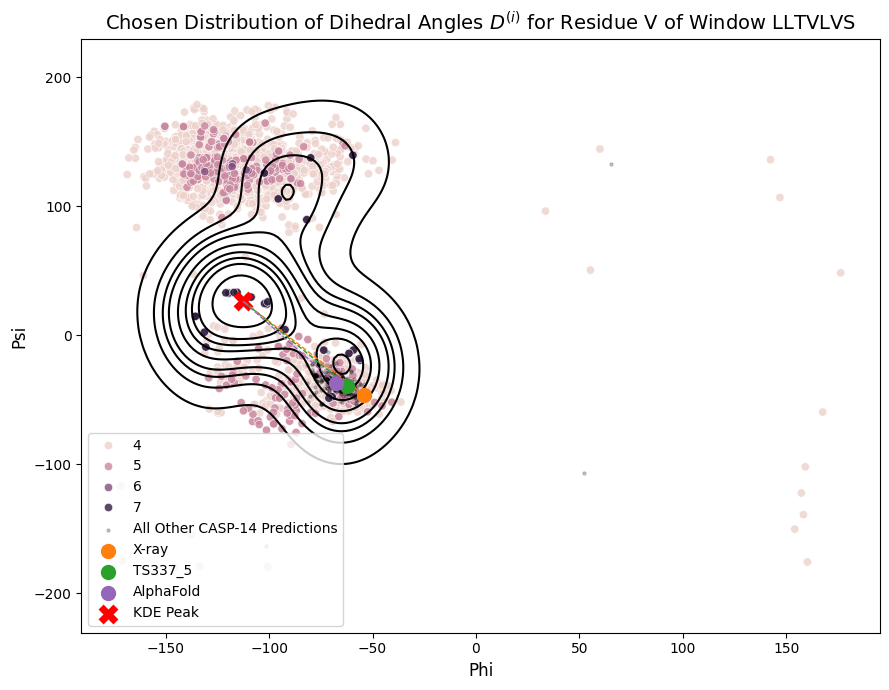

In [8]:
da = DihedralAdherence('T1024', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde', kdews=[0,0,0,1])
da.load_results()
da.plot_da_for_seq('LLTVLVS', scatter=True)